In [15]:
# Perform Monte-Carlo sims
import matplotlib.pyplot as plt 
from numpy import array, zeros, amax, mean, std, where, count_nonzero
from numpy.random import uniform, beta
from tqdm import tqdm
import multidim_stochastic_collocation as msc
from SEIRmodel import SEIRmodel, INFECTED_IX

In [2]:
# define random variable intervals 
R0_interval = [1.5, 3.0] # ~ Uniform distribution   
T_interval = [5, 10]     # ~ Uniform distribution
tau_interval = [1, 14]   # ~ Beta distribution  
beta_a = beta_b = 2      # parameters of beta distribution

# Create the collocation nodes 
clenshaw_curtis_level: int = 4
n_randvars = d_dims = 3
collocation_nodes_matrix = msc.get_clenshawcurtis_collocation_nodes_matrix(
    k=clenshaw_curtis_level, d_dims=d_dims) 

# Get the number of collocation nodes for each random var
n_nodes_per_randvar = collocation_nodes_matrix.shape[1]

# Scale the collocation nodes [-1, 1] -> [a, b] for respective random vars
collocation_nodes_matrix[0, :] = array( # scale R0 nodes
    [msc.map_uniform_val_to_new_interval(
        collocation_nodes_matrix[0, i], *R0_interval) 
        for i in range(n_nodes_per_randvar)]) 

collocation_nodes_matrix[1, :] = array( # scale T nodes
    [msc.map_uniform_val_to_new_interval(
        collocation_nodes_matrix[1, i], *T_interval) 
        for i in range(n_nodes_per_randvar)])

collocation_nodes_matrix[2, :] = array( # scale tau nodes
    [msc.map_uniform_val_to_new_interval(
        collocation_nodes_matrix[2, i], *tau_interval) 
        for i in range(n_nodes_per_randvar)])

# Compute the multi-index 
multi_index = tuple(msc.get_multi_index(collocation_nodes_matrix))

In [3]:
# Get dummy model solutions for shape purposes
seir_model_solutions = SEIRmodel(3, 3, 3)

# initialize the model evaluation cache to prevent redundantly
# computing model solution at collocation nodes
model_evaluation_cache = zeros(
        shape=(*([n_nodes_per_randvar]*n_randvars), 
                *seir_model_solutions.shape))

# precompute model at collocation nodes
for js in tqdm(
    multi_index, desc="Precompute model evaluations collocation nodes"):
    collocation_nodes_at_j = collocation_nodes_matrix[range(len(js)), js]
    model_eval = SEIRmodel(*collocation_nodes_at_j)

    # e.g., update `tensor[0, 0, 1, :, :]`  with the model evaluation
    # having used collocation nodes corresponding to multindices (0, 0, 1)
    eval_cache_ix = (*js, ...)
    model_evaluation_cache[eval_cache_ix]  = model_eval

Precompute model evaluations collocation nodes: 100%|██████████| 729/729 [00:09<00:00, 80.25it/s]


In [8]:
# Determine number of MC samples
mc_samples = 1000

# Create the Zs vector by selecting arbitrary values in the appropriate
# intervals for the random vars
R0s = uniform(*R0_interval,size=mc_samples)
Ts = uniform(*T_interval, size=mc_samples)
taus = [msc.map_beta_val_to_new_interval(val, *tau_interval) 
        for val in beta(beta_a, beta_b, size=mc_samples)]

# monte carlo sampling
Qs = []
for (R0, T, tau) in tqdm(
    zip(R0s, Ts, taus), desc="Monte-Carlo Sampling", total=len(taus)):

    Zs = [R0, T, tau]
    
    u_approx = msc.multidim_stochastic_collocation(
        Zs, model_evaluation_cache, collocation_nodes_matrix, multi_index,
        verbose = False) 
    
    infected = u_approx[:, INFECTED_IX]

    Q = amax(infected)
    Qs.append(Q)

Monte-Carlo Sampling: 100%|██████████| 1000/1000 [03:10<00:00,  5.24it/s]


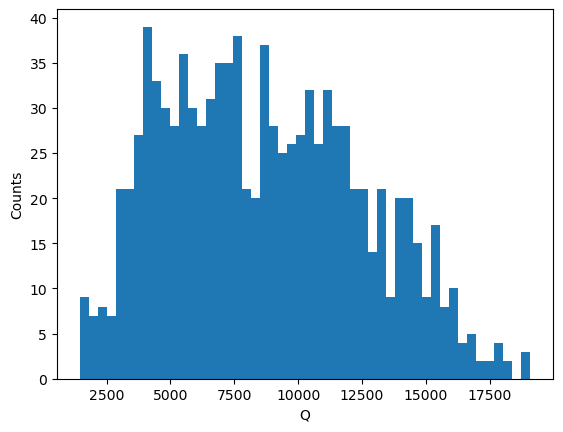

In [12]:
# Plot histogram of maximum infected Q from montecarlo sim
plt.hist(Qs, bins=50)
plt.ylabel("Counts")
plt.xlabel("Q")
plt.show()

In [17]:
Qs = array(Qs)

# Summary statistics
print(mean(Qs))
print(std(Qs))

# probability for I(t) > 15_000
count_nonzero(where(Qs > 15_000)) / mc_samples

8681.847318958959
3830.7931992458825


0.062